# Virtual Environment

In [2]:
!poetry env use 3.12
!poetry env activate

Using virtualenv: C:\Users\04n\AppData\Local\pypoetry\Cache\virtualenvs\corn-leaf-disease-classifier-davY0eoL-py3.12
"C:\Users\04n\AppData\Local\pypoetry\Cache\virtualenvs\corn-leaf-disease-classifier-davY0eoL-py3.12\Scripts\activate.bat"


In [3]:
!poetry install
!poetry lock
#!poetry run pip freeze
    # ipykernel
    # keras
    # matplotlib
    # numpy
    # ruff
    # seaborn
    # tensorflow

Installing dependencies from lock file

No dependencies to install or update
Resolving dependencies...


# Set Seed

In [4]:
import os

In [5]:
SEED = 727

In [6]:
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setup Imports

In [7]:
import keras
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [8]:
from natsort import natsorted
from numpy._typing._array_like import NDArray
import os
from pathlib import Path
from PIL import Image, ImageEnhance
from typing import Any
import random
import shutil

IMAGE_SIZE: tuple[int, int] = (64, 64)
IMAGE_SUFFIXES: set[str] = {'.jpeg', '.jpg', '.png'}

# Load Datasets

In [9]:
ROOT_PATH: Path = Path.cwd().parent
TRAIN_PATH: Path = ROOT_PATH / 'data' / 'train'
TEST_PATH: Path = ROOT_PATH / 'data' / 'test'

TRAIN_CHECKPOINT_PATH: Path = Path.cwd() / 'checkpoints'

In [10]:
def load_image_from_path(image_path: Path) -> list[int]:
    image: Image.Image = Image.open(image_path).convert('RGB').resize(IMAGE_SIZE)
    image = ImageEnhance.Color(image).enhance(2.0)

    image_flat: NDArray[Any] = np.asarray(image, dtype="int64").flatten()

    ret: list[int] = [int(i) for i in image_flat]
    return ret

In [11]:
def get_dataset_classes(dataset_path: Path) -> list[str]:
    return [d.name for d in dataset_path.iterdir() if d.is_dir()]

In [12]:
def load_dataset_from_directory(dataset_path: Path) -> pd.DataFrame:
    dataset_classes: list[str] = get_dataset_classes(dataset_path)

    labels: list[str] = ['label']
    for i in range(IMAGE_SIZE[0]):
        for j in range(IMAGE_SIZE[1]):
            for k in ['r', 'g', 'b']:
                labels.append(f'pixel{i*IMAGE_SIZE[0] + j}_{k}')

    data: dict[str, list[int]] = {}
    for label in labels:
        data[label] = []
    for d_c, dataset_class in enumerate(dataset_classes):
        image_paths: list[Path] = natsorted([image_path for image_path in (dataset_path / dataset_class).iterdir() if image_path.is_file() and image_path.suffix in IMAGE_SUFFIXES])
        for image_path in image_paths:
            row: list[int] = [d_c]
            row.extend(load_image_from_path(image_path))

            for i in range(len(labels)):
                data[labels[i]].append(row[i])

    ret: pd.DataFrame = pd.DataFrame(
        data=data,
        )

    return ret

In [13]:
train: pd.DataFrame = load_dataset_from_directory(TRAIN_PATH)
print(train.shape)
train.head()

(3350, 12289)


,label,pixel0_r,pixel0_g,pixel0_b,pixel1_r,pixel1_g,pixel1_b,pixel2_r,pixel2_g,pixel2_b,...,pixel4092_b,pixel4093_r,pixel4093_g,pixel4093_b,pixel4094_r,pixel4094_g,pixel4094_b,pixel4095_r,pixel4095_g,pixel4095_b
0,0,136,152,190,139,155,193,133,149,185,...,121,255,194,116,255,193,115,254,188,106
1,0,98,152,112,110,144,122,129,145,147,...,9,37,91,11,41,95,13,63,95,17
2,0,32,20,0,38,24,0,61,39,9,...,0,75,41,0,62,38,0,25,21,0
3,0,175,159,185,181,165,191,181,165,191,...,156,159,137,145,122,102,116,110,94,110
4,0,175,153,165,175,153,165,177,155,167,...,169,157,141,171,158,142,172,162,146,176


In [14]:
'''
test: pd.DataFrame = load_dataset_from_directory(TEST_PATH)
print(test.shape)
#test.head()
'''

'\ntest: pd.DataFrame = load_dataset_from_directory(TEST_PATH)\nprint(test.shape)\n#test.head()\n'

# Reset Seed

- if only tweaking model parameters (after already running the entire notebook once), then just **Execute Cell and Below** from here (no need to reload entire dataset)

In [15]:
def set_seeds(seed: int) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    keras.utils.set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

In [16]:
set_seeds(SEED)

# Data Preprocessing

## Create DataFrames

In [17]:
Y_train: pd.Series = train['label']
X_train: pd.DataFrame = train.drop(
    labels = ['label'],
    axis = 1
    )
Y_train.value_counts()

label
1    1045
3     929
0     917
2     459
Name: count, dtype: int64

## Normalization, Reshape and Label Encoding 

In [18]:
NUM_CLASSES: int = len(get_dataset_classes(TRAIN_PATH))
NUM_CLASSES

4

In [19]:
# normalize train data
X_train /= 255.0
#X_train *= X_train
print("X_train shape: ", X_train.shape)

X_train shape:  (3350, 12288)


In [20]:
'''
test /= 255.0
print("test shape: ", test.shape)
'''

'\ntest /= 255.0\nprint("test shape: ", test.shape)\n'

In [21]:
# reshape, supports shape inference using `-1` as dimension
X_train: pd.DataFrame = X_train.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print("X_train shape: ", X_train.shape)

X_train shape:  (3350, 64, 64, 3)


In [22]:
'''
test = test.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print("test shape: ", test.shape)
'''

'\ntest = test.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)\nprint("test shape: ", test.shape)\n'

In [23]:
# Label Encoding 
from keras.utils import to_categorical # convert to one-hot-encoding

Y_train: NDArray[np.float64] = to_categorical(Y_train, num_classes=NUM_CLASSES)

## Train Test Split

In [24]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2

In [25]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=TEST_SIZE, random_state=SEED)
print("x_train shape", X_train.shape)
print("x_test shape", X_val.shape)
print("y_train shape", Y_train.shape)
print("y_test shape", Y_val.shape)

x_train shape (2680, 64, 64, 3)
x_test shape (670, 64, 64, 3)
y_train shape (2680, 4)
y_test shape (670, 4)


## Get Class Weights

In [26]:
from sklearn.utils import class_weight

CLASS_WEIGHTS: NDArray[np.float64] = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.array([i for i in range(NUM_CLASSES)]),
    y = np.argmax(Y_val, axis = 1)
    )

CLASS_WEIGHTS_DICT: dict[int, np.float64] = {k: v for k, v in enumerate(CLASS_WEIGHTS)}

CLASS_WEIGHTS_DICT

{0: np.float64(0.9005376344086021),
 1: np.float64(0.7863849765258216),
 2: np.float64(1.8206521739130435),
 3: np.float64(0.9357541899441341)}

# CNN

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam, SGD
#from keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

In [32]:
# optimizer, loss, etrics
#'''
OPTIMIZER = Adam(
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999
    )
'''
OPTIMIZER = SGD(
    learning_rate = 0.0075,
)
'''
LOSS: str = 'categorical_crossentropy'
METRICS: list[str] = ['accuracy', 'precision', 'recall', 'f1_score']

# epochs, batch size
EPOCHS = 250
BATCH_SIZE = 64

## Create Model Layers

In [30]:
# CNN model layers
model = Sequential()

#
model.add(Conv2D(
    filters = 16,
    kernel_size = (5,5),
    padding = 'Same', 
    activation = 'relu',
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    ))
model.add(MaxPool2D(
    pool_size = (2,2)
    ))
model.add(Dropout(0.2))

#
model.add(Conv2D(
    filters = 32,
    kernel_size = (3,3),
    padding = 'Same', 
    activation = 'relu'))
model.add(MaxPool2D(
    pool_size = (2,2),
    strides = (2,2)
    ))
model.add(Dropout(0.35))

# fully connected
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

## Model Compile

In [31]:
# compile the model
model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
    )

## Data Augmentation

In [32]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # dimemsion reduction
        rotation_range = 120,  # randomly rotate images in the range 90 degrees
        zoom_range = 0.4, # Randomly zoom image 40%
        width_shift_range = 0.2,  # randomly shift images horizontally 20%
        height_shift_range = 0.2,  # randomly shift images vertically 20%
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True)  # randomly flip images

datagen.fit(
    X_train,
    seed=SEED
    )

## Model Callbacks

In [33]:
# if checkpoint folder exists, then delete all existing checkpoints
if TRAIN_CHECKPOINT_PATH.exists():
    for checkpoint_path in TRAIN_CHECKPOINT_PATH.iterdir():
        if checkpoint_path.is_file():
            checkpoint_path.unlink()

# add a ModelCheckpoint to save new best models
model_checkpoint = ModelCheckpoint(
    filepath = TRAIN_CHECKPOINT_PATH / 'checkpoint_{epoch:03d}-{val_loss:.4f}.keras', 
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    save_freq = 'epoch'
    )

In [34]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    restore_best_weights=False,
    start_from_epoch=20,
)

## Model Fit

In [35]:
# fit the model
history = model.fit(
    datagen.flow(
        X_train, Y_train,
        batch_size = BATCH_SIZE
    ),
    epochs = EPOCHS,
    validation_data = (X_val, Y_val),
    class_weight = CLASS_WEIGHTS_DICT,
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
    callbacks = [model_checkpoint, early_stopping],
    )

Epoch 1/250
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.3724 - f1_score: 0.3412 - loss: 1.4160 - precision: 0.3775 - recall: 0.0792 - val_accuracy: 0.6030 - val_f1_score: 0.4845 - val_loss: 0.9317 - val_precision: 0.6939 - val_recall: 0.3045
Epoch 2/250
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5000 - f1_score: 0.4456 - loss: 1.0756 - precision: 0.5750 - recall: 0.3594 - val_accuracy: 0.6552 - val_f1_score: 0.5282 - val_loss: 0.8740 - val_precision: 0.7955 - val_recall: 0.3194
Epoch 3/250
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.6803 - f1_score: 0.6366 - loss: 0.8124 - precision: 0.7434 - recall: 0.5269 - val_accuracy: 0.8015 - val_f1_score: 0.7510 - val_loss: 0.5594 - val_precision: 0.9515 - val_recall: 0.5851
Epoch 4/250
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7188 - f1_score: 0.6919 - loss: 0.7553 - precision: 0.8085 - recall: 0.5938 - val_accuracy: 0.7970 - val_f1_score: 0.7364 - val_loss: 0.5548 - val_precision: 0.9499 - val_reca

# Evaluation Metrics

## History Curves

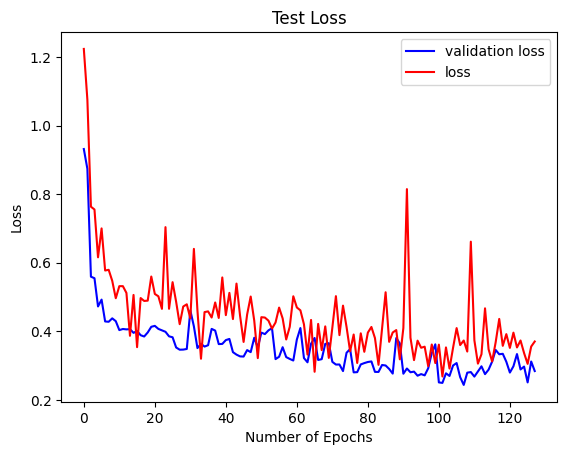

In [36]:
# Plot the loss curves for training and validation 
plt.plot(
    history.history['val_loss'],
    color='b',
    label="validation loss"
    )
plt.plot(
    history.history['loss'],
    color='r',
    label="loss"
    )

# set plot title and axis labels
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()

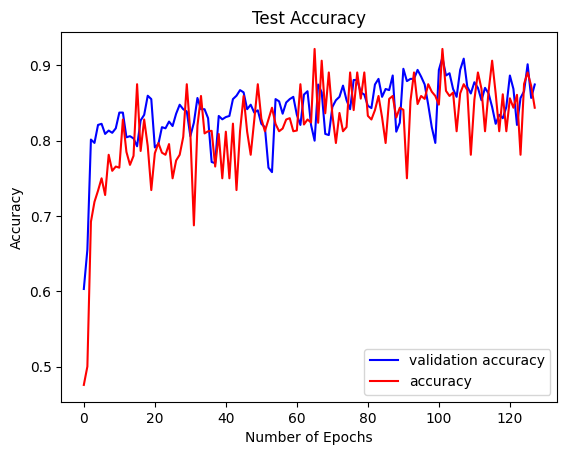

In [37]:
# Plot the accuracy curves for training and validation
if 'accuracy' in METRICS:
    plt.plot(
        history.history['val_accuracy'],
        color='b',
        label="validation accuracy"
        )
    plt.plot(
        history.history['accuracy'],
        color='r',
        label="accuracy"
        )

    # set plot title and axis labels
    plt.title("Test Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # show plot
    plt.show()

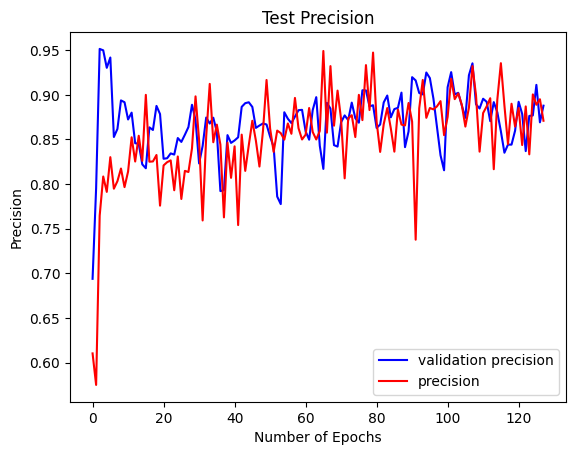

In [38]:
# Plot the precision curves for training and validation 
if 'precision' in METRICS:
    plt.plot(
        history.history['val_precision'],
        color='b',
        label="validation precision"
        )
    plt.plot(
        history.history['precision'],
        color='r',
        label="precision"
        )

    # set plot title and axis labels
    plt.title("Test Precision")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Precision")
    plt.legend()

    # show plot
    plt.show()

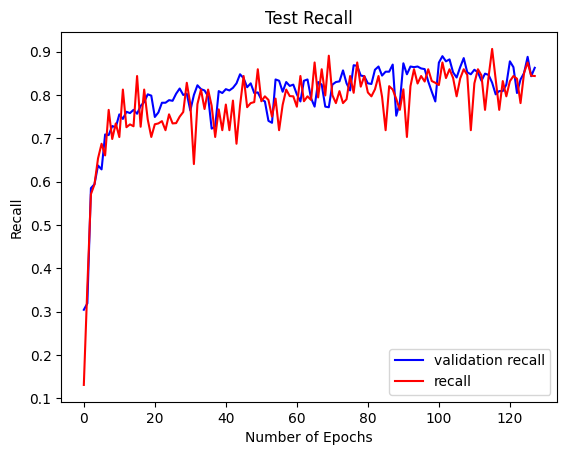

In [39]:
# Plot the recall curves for training and validation
if 'recall' in METRICS:
    plt.plot(
        history.history['val_recall'],
        color='b',
        label="validation recall"
        )
    plt.plot(
        history.history['recall'],
        color='r',
        label="recall"
        )

    # set plot title and axis labels
    plt.title("Test Recall")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Recall")
    plt.legend()

    # show plot
    plt.show()

In [40]:
history.history['val_f1_score'][69]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.5703703 , 0.95883775, 0.5938566 , 0.9835164 ], dtype=float32)>

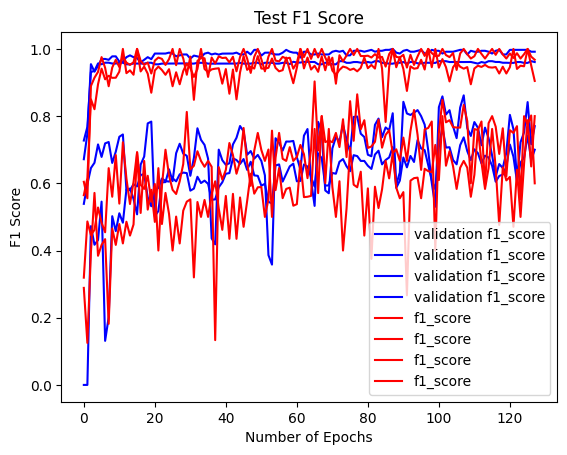

In [41]:
# Plot the F1 score curves for training and validation
if 'f1_score' in METRICS:
    plt.plot(
        history.history['val_f1_score'],
        color='b',
        label="validation f1_score"
        )
    plt.plot(
        history.history['f1_score'],
        color='r',
        label="f1_score"
        )

    # set plot title and axis labels
    plt.title("Test F1 Score")
    plt.xlabel("Number of Epochs")
    plt.ylabel("F1 Score")
    plt.legend()

    # show plot
    plt.show()

## Confusion Matrix

In [33]:
from numpy import ndarray

In [34]:
# load best saved weights into model
for checkpoint_path in TRAIN_CHECKPOINT_PATH.iterdir():
    model = keras.saving.load_model(checkpoint_path)

In [35]:
# confusion matrix
def generate_confusion_matrix(X_data, Y_data, labels) -> ndarray[Any, Any]:
    # Predict the values from the validation dataset
    Y_pred = model.predict(X_data)

    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred, axis=1) 

    # Convert validation observations to one hot vectors
    Y_true = np.argmax(Y_data, axis=1) 

    # compute the confusion matrix
    confusion_mtx: ndarray[Any, Any] = confusion_matrix(Y_true, Y_pred_classes) 

    # plot the confusion matrix
    f: matplotlib.figure.Figure; ax: plt.Axes
    f, ax = plt.subplots(figsize=(8, 8))

    # generate confusion matrix as heatmap
    sns.heatmap(
        confusion_mtx,
        annot=True,
        linewidths=0.01,
        cmap="Greens",
        linecolor="gray",
        fmt='.1f',
        ax=ax,
        xticklabels=labels,
        yticklabels=labels,
        )

    # set title and axis labels of confusion matrix
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # show confusion matrix
    plt.show()

    # return raw confusion matrix
    return confusion_mtx

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


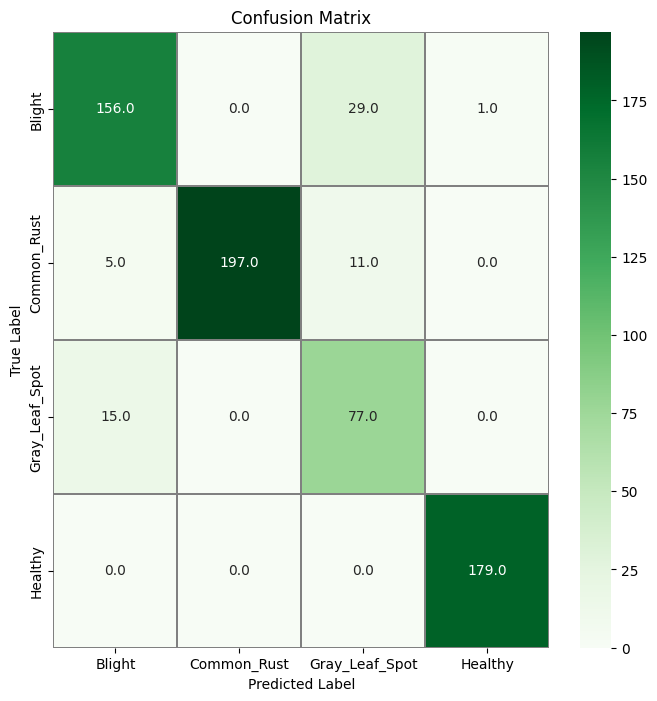

array([[156,   0,  29,   1],
       [  5, 197,  11,   0],
       [ 15,   0,  77,   0],
       [  0,   0,   0, 179]])

In [36]:
generate_confusion_matrix(X_val, Y_val, get_dataset_classes(TRAIN_PATH))

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


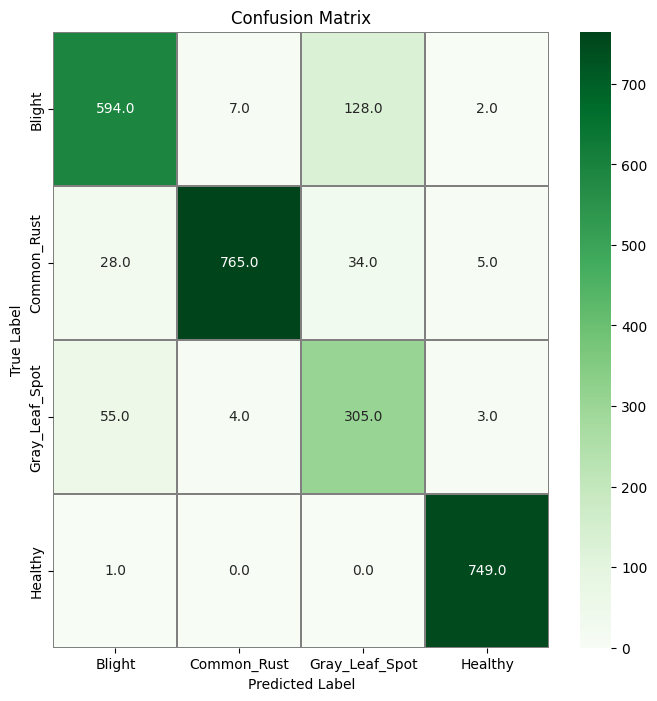

array([[594,   7, 128,   2],
       [ 28, 765,  34,   5],
       [ 55,   4, 305,   3],
       [  1,   0,   0, 749]])

In [37]:
generate_confusion_matrix(X_train, Y_train, get_dataset_classes(TRAIN_PATH))

## Classification Report

In [38]:
# classification_report
def generate_classification_report(X_data, Y_data, labels) -> None:
    # Predict the values from the validation dataset
    Y_pred = model.predict(X_data)

    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred, axis=1) 

    # Convert validation observations to one hot vectors
    Y_true = np.argmax(Y_data, axis=1) 

    print(classification_report(Y_true, Y_pred_classes, target_names=get_dataset_classes(TRAIN_PATH)))

In [39]:
generate_classification_report(X_val, Y_val, get_dataset_classes(TRAIN_PATH))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                precision    recall  f1-score   support

        Blight       0.89      0.84      0.86       186
   Common_Rust       1.00      0.92      0.96       213
Gray_Leaf_Spot       0.66      0.84      0.74        92
       Healthy       0.99      1.00      1.00       179

      accuracy                           0.91       670
     macro avg       0.88      0.90      0.89       670
  weighted avg       0.92      0.91      0.91       670



In [40]:
generate_classification_report(X_train, Y_train, get_dataset_classes(TRAIN_PATH))

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                precision    recall  f1-score   support

        Blight       0.88      0.81      0.84       731
   Common_Rust       0.99      0.92      0.95       832
Gray_Leaf_Spot       0.65      0.83      0.73       367
       Healthy       0.99      1.00      0.99       750

      accuracy                           0.90      2680
     macro avg       0.88      0.89      0.88      2680
  weighted avg       0.91      0.90      0.90      2680



# Export Results

In [41]:
import pickle

## Save Best Model

In [42]:
BEST_MODEL_FILENAME: str = 'model.keras'

In [43]:
BEST_MODEL_PATH: Path = Path.cwd() / 'final' / BEST_MODEL_FILENAME

keras.saving.save_model(model, BEST_MODEL_PATH)

## Save CSV

In [44]:
CSV_FILENAME = 'predictions.csv'

In [45]:
def predict_images(image_directory: Path) -> list[tuple[str, str]]:
    image_paths: list[Path] = [image_path for image_path in image_directory.iterdir() if image_path.is_file() and image_path.suffix in IMAGE_SUFFIXES]
    images: list[Image.Image] = [load_image_from_path(image_path) for image_path in image_paths]

    image_arrays = np.array(images).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

    pred = model.predict(image_arrays)
    pred_classes = np.argmax(pred, axis=1)
    predictions = [get_dataset_classes(TRAIN_PATH)[i] for i in pred_classes]

    zipped_predictions: list[tuple[Path, str]] = [(image_path, str(prediction)) for image_path, prediction in zip(image_paths, predictions)]
    
    return natsorted([(p[0].name, p[1]) for p in zipped_predictions])

In [46]:
CSV_PATH: Path = Path.cwd() / 'final' / CSV_FILENAME

with open(CSV_PATH, 'w') as csv_file:
    csv_file.write('\n'.join(map(','.join, predict_images(TEST_PATH))))

predict_images(TEST_PATH)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[('0.jpeg', 'Healthy'),
 ('1.jpeg', 'Healthy'),
 ('2.jpeg', 'Healthy'),
 ('3.jpeg', 'Healthy'),
 ('4.jpeg', 'Healthy'),
 ('5.jpeg', 'Healthy'),
 ('6.jpeg', 'Healthy'),
 ('7.jpeg', 'Healthy'),
 ('8.jpeg', 'Healthy'),
 ('9.jpeg', 'Healthy'),
 ('10.jpeg', 'Healthy'),
 ('11.jpeg', 'Healthy'),
 ('12.jpeg', 'Healthy'),
 ('13.jpeg', 'Healthy'),
 ('14.jpeg', 'Healthy'),
 ('15.jpeg', 'Healthy'),
 ('16.jpeg', 'Healthy'),
 ('17.jpeg', 'Healthy'),
 ('18.jpeg', 'Healthy'),
 ('19.jpeg', 'Healthy'),
 ('20.jpeg', 'Healthy'),
 ('21.jpeg', 'Healthy'),
 ('22.jpeg', 'Healthy'),
 ('23.jpeg', 'Healthy'),
 ('24.jpeg', 'Healthy'),
 ('25.jpeg', 'Healthy'),
 ('26.jpeg', 'Healthy'),
 ('27.jpeg', 'Healthy'),
 ('28.jpeg', 'Healthy'),
 ('29.jpeg', 'Healthy'),
 ('30.jpeg', 'Healthy'),
 ('31.jpeg', 'Healthy'),
 ('32.jpeg', 'Healthy'),
 ('33.jpeg', 'Healthy'),
 ('34.jpeg', 'Healthy'),
 ('35.jpeg', 'Healthy'),
 ('36.jpeg', 'Healthy'),
 ('37.jpeg', 'Healthy'),
 ('38.jpeg', 'Healthy'),
 ('39.jpeg', 'Healthy'),
 ('40.jpeg

## Save Model History

In [47]:
HISTORY_FILENAME = 'history.obj'

In [48]:
pickle.dump(history, open(Path.cwd() / 'final' / HISTORY_FILENAME, 'wb'))

NameError: name 'history' is not defined